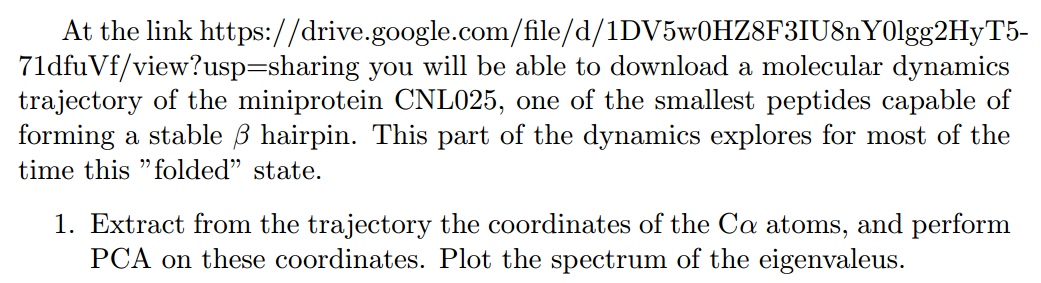

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda

In [2]:
def readtraj(PDB):
    with open(PDB) as f:
        line = f.readline()
        ca_coord=[]
        while line:
            line = f.readline()
            while ("END" not in line) and line:
                if "CA" in line:
                    coord = line.split()[6:9]
                    ca_coord += coord
                line = f.readline()
    return np.array(ca_coord).reshape((-1,30)).astype(float).transpose()


In [3]:
PDB = 'CLN025.pdb'
traj = readtraj(PDB)
N = len(traj[0,:])
D = len(traj[:,0])

In [4]:
# COVARIANCE MATRIX
def CovMatrix(x):
    C = np.zeros((D,D))
    for i in range(D):
        for j in range(D):
            C[i,j] = np.dot(x[i,:],x[j,:])/N - np.average(x[i,:])*np.average(x[j,:])
    return C

In [5]:
C = CovMatrix(traj[:,:])
eigenvalues , eigenvectors = np.linalg.eigh(C)

(0.0, 69.28242091906725)

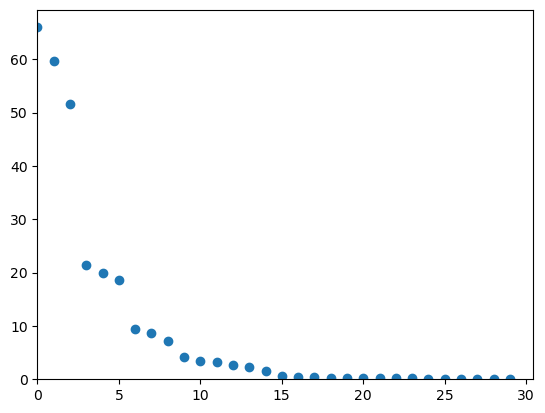

In [6]:
plt.plot(eigenvalues[::-1], linestyle = ' ', marker = 'o')
plt.xlim((0,None))
plt.ylim((0,None))
#plt.yscale('log')

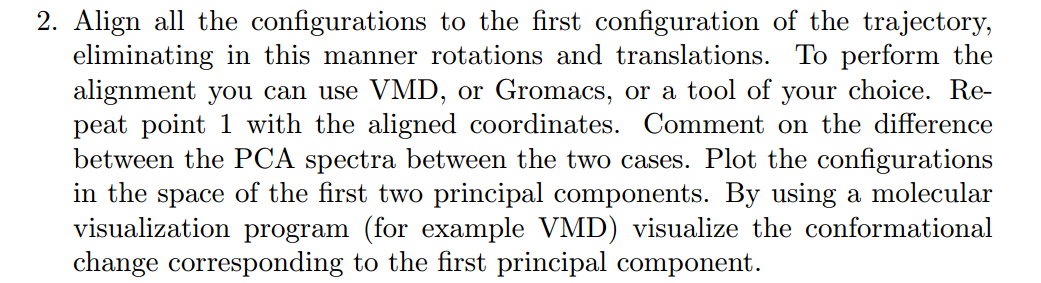

In [7]:
PDB = 'aligned.pdb'
aligned_traj = readtraj(PDB)
C_aligned = CovMatrix(aligned_traj)
eigenvalues_aligned, eigenvectors_aligned = np.linalg.eig(C_aligned)

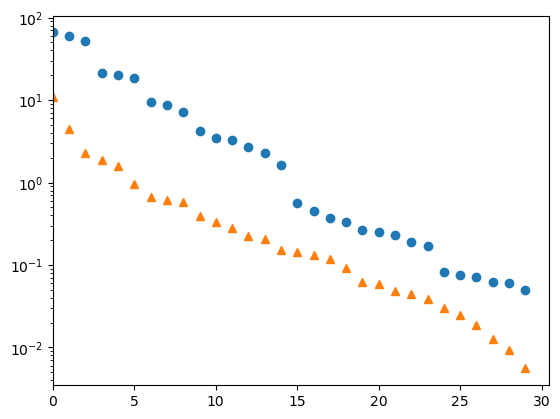

In [8]:
plt.plot(np.sort(eigenvalues)[::-1], linestyle = ' ', marker = 'o')
plt.plot(np.sort(eigenvalues_aligned)[::-1], linestyle = ' ', marker = '^')
plt.xlim((0,None))
#plt.ylim((,None))
plt.yscale('log')
plt.show()

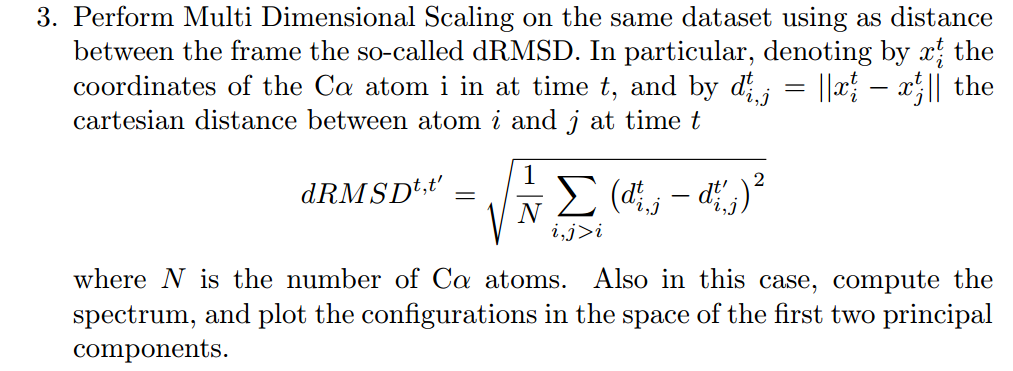

In [9]:

#define dRMSD
def dRMSDmatrix(trajectory):
    dRMSDmatrix = np.zeros((N,N))
    for t1 in range(N):
        if (t1/N*100)%10 == 0:
            print(f'{t1/N * 100:.0f}%')
        for t2 in range(t1,N):
            sum = 0

            for i in range(D//3):
                for j in range(i+1, D//3):
                    x_i_t1 = trajectory[3*i:3*(i+1),t1]
                    x_j_t1 = trajectory[3*j:3*(j+1),t1]
                    d_ij_t1 = np.linalg.norm(x_i_t1 - x_j_t1)

                    x_i_t2 = trajectory[3*i:3*(i+1),t2]
                    x_j_t2 = trajectory[3*j:3*(j+1),t2]
                    d_ij_t2 = np.linalg.norm(x_i_t2 - x_j_t2)

                    sum += (d_ij_t1 - d_ij_t2)**2
    
            dRMSDmatrix[t1,t2] = np.sqrt(sum/(D/3))
            dRMSDmatrix[t2,t1] = dRMSDmatrix[t1,t2]
    return dRMSDmatrix

def GrahmMatrix(distMatrix):
    G = distMatrix +  np.average(distMatrix) - np.average(distMatrix, axis=0) - np.average(distMatrix, axis = 1).reshape((N,1))
    return -.5*G

In [10]:
if not os.path.exists('dist_matrix.txt'):
    dist = dRMSDmatrix(aligned_traj)
    np.savetxt('dist_matrix.txt', dist)
else:
    dist = np.loadtxt('dist_matrix.txt')

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%


In [11]:
G = GrahmMatrix(dist)
G_eigenvalues , G_eigenvectors = np.linalg.eigh(G)

In [12]:
print(np.average(G))

-3.1429614466560453e-16


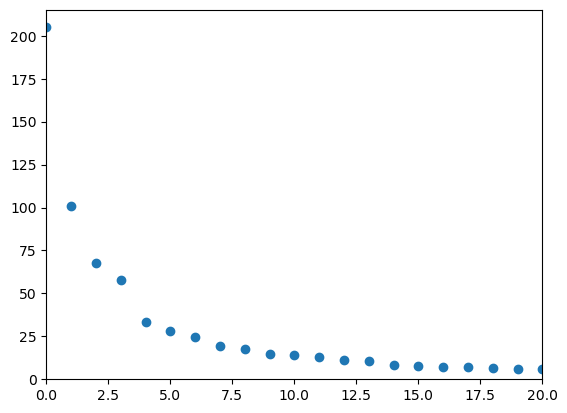

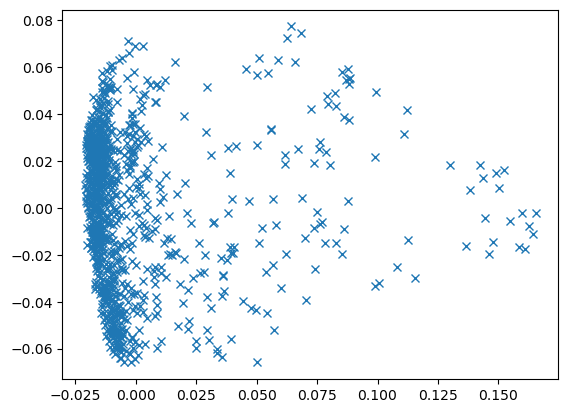

In [14]:
plt.plot(G_eigenvalues[::-1], linestyle = ' ', marker = 'o')
plt.xlim((0,20))
plt.ylim((0,None))
#plt.yscale('log')
plt.figure()
plt.plot(G_eigenvectors[:,-1], G_eigenvectors[:,-2], marker='x', linestyle = ' ')